In [1]:
import os
import json
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import Polygon
import numpy as np
import xarray as xr
import rioxarray as rxr
import geoviews as gv
import geoviews.feature as gf
import hvplot.pandas
import s3fs

## Define functions from Emma's its_live tutorial

In [29]:
# THIS IS FROM EMMA's TUTORIAL https://github.com/e-marshall/itslivetools/blob/main/itslivetools/access.py
def find_granule_by_point(input_point, label='single_point'):
    '''returns url for the granule (zarr datacube) containing a specified point. point must be passed in epsg:4326
    '''
    catalog = gpd.read_file('https://its-live-data.s3.amazonaws.com/datacubes/catalog_v02.json')

    #make shapely point of input point
    p = gpd.GeoSeries([Point(input_point[0], input_point[1])],crs='EPSG:4326')
    #make gdf of point
    gdf = gdf = gpd.GeoDataFrame({'label': f'{label}', 
                                  'geometry':p})

    #find row of granule 
    granule = catalog.sjoin(gdf, how='inner')

    url = granule['zarr_url'].values[0]
    return URL
    
def read_in_s3(http_url, chunks='auto'):
    ''' does some string formatting from zarr url and returns xarray dataset
    '''

    s3_url = http_url.replace('http','s3')
    s3_url = s3_url.replace('.s3.amazonaws.com','')

    datacube = xr.open_dataset(s3_url, engine='zarr',
                               storage_options={'anon':True},
                               chunks=chunks)
    return datacube


In [132]:
catalog = gpd.read_file('https://its-live-data.s3.amazonaws.com/datacubes/catalog_v02.json') # ITS_LIVE data catalog where all the paths are defined

In [139]:
# KUJ polygon from Kevin
# Read in polygon and get centroid to join with its_live data catalog
path = 'edia/laserglaciers/upernavik/its_live_tutorial/geoms/2020_12_11_term_polygon.shp'
kuj_poly = gpd.read_file(path)
kuj_centroid = kuj_poly.centroid
kuj_centroid = gpd.GeoDataFrame(geometry=kuj_centroid,crs=4326)
granule = catalog.sjoin(kuj_centroid, how='inner')
url = granule['zarr_url'].values[0]

/tmp/ipykernel_127113/1650650115.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  kuj_centroid = kuj_poly.centroid


In [36]:
kuj_vels = read_in_s3(url)
kuj_vels = kuj_vels.chunk({"mid_date": len(kuj_vels.mid_date)}) # setting the mid_date chunksize to the time dimensions helps A LOT
kuj_vels = kuj_vels.sortby('mid_date')

In [37]:
kuj_vels

<xarray.Dataset>
Dimensions:                     (mid_date: 49475, y: 834, x: 833)
Coordinates:
  * mid_date                    (mid_date) datetime64[ns] 1984-10-21T14:23:16...
  * x                           (x) float64 -1.999e+05 -1.997e+05 ... -1e+05
  * y                           (y) float64 -2.1e+06 -2.1e+06 ... -2.2e+06
Data variables: (12/60)
    M11                         (mid_date, y, x) float32 dask.array<chunksize=(49475, 20, 20), meta=np.ndarray>
    M11_dr_to_vr_factor         (mid_date) float32 dask.array<chunksize=(49475,), meta=np.ndarray>
    M12                         (mid_date, y, x) float32 dask.array<chunksize=(49475, 20, 20), meta=np.ndarray>
    M12_dr_to_vr_factor         (mid_date) float32 dask.array<chunksize=(49475,), meta=np.ndarray>
    acquisition_date_img1       (mid_date) datetime64[ns] dask.array<chunksize=(49475,), meta=np.ndarray>
    acquisition_date_img2       (mid_date) datetime64[ns] dask.array<chunksize=(49475,), meta=np.ndarray>
    ...                          ...
    vy_error_modeled            (mid_date) float32 dask.array<chunksize=(49475,), meta=np.ndarray>
    vy_error_slow               (mid_date) float32 dask.array<chunksize=(49475,), meta=np.ndarray>
    vy_error_stationary         (mid_date) float32 dask.array<chunksize=(49475,), meta=np.ndarray>
    vy_stable_shift             (mid_date) float32 dask.array<chunksize=(49475,), meta=np.ndarray>
    vy_stable_shift_slow        (mid_date) float32 dask.array<chunksize=(49475,), meta=np.ndarray>
    vy_stable_shift_stationary  (mid_date) float32 dask.array<chunksize=(49475,), meta=np.ndarray>
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               26-Sep-2023 03:06:33
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/N70W040/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/N70W040/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

## Check data quality 
Lots of data can be empty 

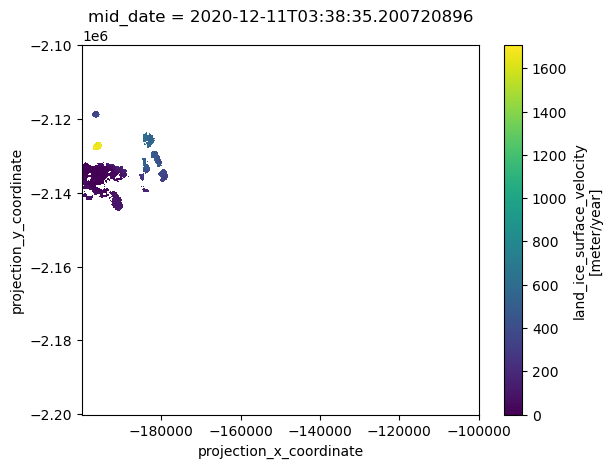

In [133]:
date = np.datetime64(os.path.split(path)[1][:10].replace('_','-'))
kuj_vels_sample = kuj_vels.sel(mid_date=slice(date,date + 1))
kuj_vels_sample.isel(mid_date=0).v.plot()

## Clip data to area of interest
There is probably a more effiecient way to do this, possibly some zonal statistics with https://xcdat.readthedocs.io/en/latest/index.html or https://xarray-spatial.org/reference/_autosummary/xrspatial.zonal.stats.html

In [86]:
kuj_vels_sample = kuj_vels_sample.rio.write_crs('EPSG:3413')
kuj_poly_3413 = kuj_poly.to_crs(3413)
kuj_vels_sample_clip = kuj_vels_sample.rio.clip(kuj_poly_3413.geometry.values,kuj_poly_3413.crs,drop=True,invert=False)

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

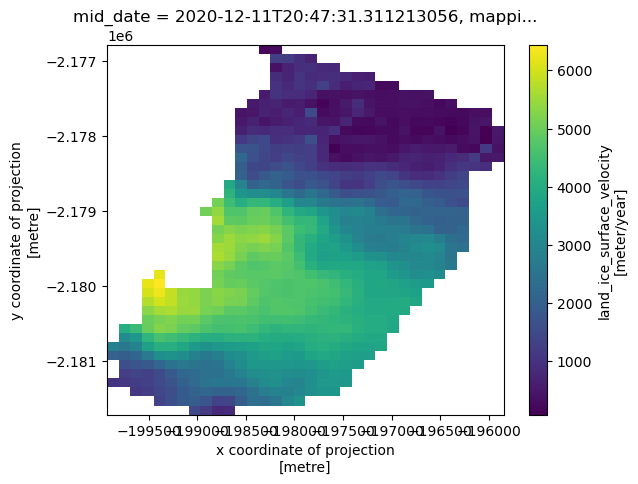

In [131]:
kuj_vels_sample_clip.v.isel(mid_date=13).plot()

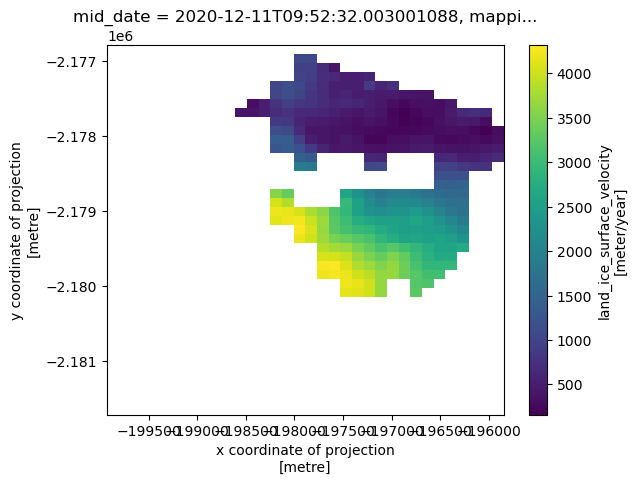

In [127]:
kuj_vels_sample_clip.v.isel(mid_date=10).plot()

In [130]:
mean_13 = np.nanmean(kuj_vels_sample_clip.v.isel(mid_date=13).values)
mean_10 = np.nanmean(kuj_vels_sample_clip.v.isel(mid_date=10).values)
print(f'mean value at mid_date 13 = {mean_13}\nmean value at mid_date 10 = {mean_10}')

mean value at mid_date 13 = 2690.330810546875
mean value at mid_date 10 = 1698.2054443359375


## Thoughs
I just manually checked the averages from a clipped KUJ terminus region. I imagine there is a better way to do this by finding the percentage or proportions of pixels in the area of interest. Then when that is done we can apply this to the lagrangian method and create the time series of interest.  